In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import warnings
import preprocessing
import model
import evaluation

warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
if torch.cuda.is_available():
    print(f"Deploying GPU.")
    device = torch.device("cuda")
else:
    print("GPU is NOT available. CPU will be deployed.")
    device = None

Deploying GPU.


In [3]:
# aggregated_withsolar.csv is the aggregation of all solar customers
data = pd.read_csv("data/aggregated_withsolar.csv")
data["solar"] = data["solar"].apply(lambda x: max(x, 0))

In [4]:
# Preprocess data
latitude = 30.29
longitude = -97.69
data = preprocessing.data_preprocessing(data, longitude, latitude)

train_data = torch.tensor(np.array(data, dtype=float)).to(device)
true_solar = torch.tensor(np.array(data.solar, dtype=float)).to(device)
train_net = torch.tensor(np.array(data.grid, dtype=float)).to(device)
train_net = train_net.reshape(train_net.shape[0], -1).to(device)

In [5]:
# Training
criterion = nn.MSELoss()
learning_rate = 0.1
epochs = 20000
model_train = model.PhysicalModel(latitude).to(device)
optimizer = torch.optim.Adam(model_train.parameters(), lr=learning_rate)
loss_total = []
for epoch in range(epochs):
    y = model_train(train_data.float())
    loss = criterion(y, true_solar.float())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    loss_total.append(loss.cpu().detach())
    model_train.capacity.data = torch.clip(model_train.capacity.data, 0, 1000)
    if epoch % 2000 == 0:
        print(f"Training Epochs: {epoch} Training Loss: {loss.item()}")

Training Epochs: 0 Training Loss: 62933.359375
Training Epochs: 2000 Training Loss: 39483.62109375
Training Epochs: 4000 Training Loss: 22724.173828125
Training Epochs: 6000 Training Loss: 11387.5703125
Training Epochs: 8000 Training Loss: 4751.09912109375
Training Epochs: 10000 Training Loss: 1935.885498046875
Training Epochs: 12000 Training Loss: 1397.45263671875
Training Epochs: 14000 Training Loss: 1382.7286376953125
Training Epochs: 16000 Training Loss: 1382.704833984375
Training Epochs: 18000 Training Loss: 1382.704833984375


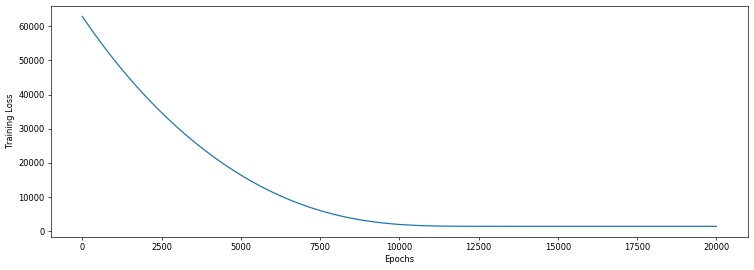

In [6]:
fig = plt.figure(figsize=(15, 5), dpi=60)
plt.plot(range(len(loss_total)), loss_total)
plt.xlabel("Epochs")
plt.ylabel("Training Loss")
plt.show()

In [7]:
# Define a function that does post disaggregation correction:
# if the estimated load is negative, the corresponding solar will be reestimated
def post_disaggregation_correction(data, model_train):
    data_total = torch.tensor(np.array(data)).to(device)
    data["prediction"] = model_train(data_total).cpu().detach().numpy()
    data["prediction"] = data["prediction"].apply(lambda x: max(0, x))

    col = "prediction"
    solar_corr = []
    for i in range(len(data)):
        if data.iloc[i][col] + data.iloc[i]["grid"] < 0:
            solar_corr.append(-data.iloc[i]["grid"])
        else:
            solar_corr.append(data.iloc[i][col])
    data["prediction"] = solar_corr
    data["load"] = data["prediction"] + data["grid"]

    data["load"] = data["load"].replace(0.0, np.nan)
    data["load"].interpolate(
        method="linear", limit_direction="forward", inplace=True, axis=0
    )
    data["prediction"] = data["load"] - data["grid"]
    return data

In [8]:
data = post_disaggregation_correction(data, model_train)

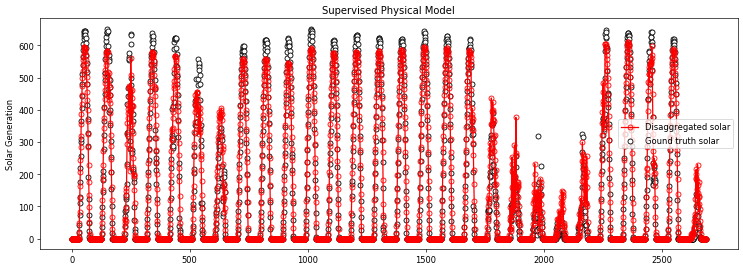

In [9]:
fig = plt.figure(figsize=(15, 5), dpi=60)
plt.scatter(range(len(data)), data.solar, marker="o", c="white", edgecolors="black")
plt.plot(
    range(len(data)),
    data.prediction,
    marker="o",
    color="red",
    markerfacecolor="none",
)
plt.ylabel("Solar Generation")
plt.title("Supervised Physical Model")
plt.legend(["Disaggregated solar", "Gound truth solar"])
plt.show()

In [10]:
# Evaluate the performance of this supervised model
MSE, MASE, CV = evaluation.model_evaluation(data)
MSE, MASE, CV

(array([1382.7465418]), array([1.40990423]), array([0.27052531]))